In [1]:
import pandas as pd
import aeon.io.api as aeon
import matplotlib.pyplot as plt
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled
from aeon.io.reader import Chunk

In [2]:
root = '/ceph/aeon/aeon/data/raw'
events = aeon.load(root, exp02.ExperimentalMetadata.SubjectState)     # load all sessions

In [3]:
sessions = events[events.id.str.startswith('BAA')]                    # take only proper visits
if len(sessions) % 2 != 0:                                            # if number of visits don't pair up
    sessions = sessions.drop(sessions.index[-1])                      # drop last visits (might be ongoing)
sessions = visits(sessions)                                           # compute visit duration
sessions = sessions[sessions.duration > pd.Timedelta(0)]              # filter any visits with zero duration
sessions

,id,weight_enter,weight_exit,enter,exit,duration
0,BAA-1100700,26.4,28.1,2022-02-23 14:21:25.550300121,2022-02-25 16:00:50.076419830,2 days 01:39:24.526119709
1,BAA-1100700,25.5,28.45,2022-03-02 13:47:43.875840187,2022-03-02 18:14:47.459969997,0 days 04:27:03.584129810
2,BAA-1100700,24.55,24.55,2022-03-04 14:00:01.818980217,2022-03-04 14:00:49.259260178,0 days 00:00:47.440279961
3,BAA-1100700,24.55,28.27,2022-03-04 14:04:16.610499859,2022-03-04 19:24:41.778140068,0 days 05:20:25.167640209
4,BAA-1100700,24.8,24.8,2022-03-15 10:30:58.058499813,2022-03-15 10:35:05.205470085,0 days 00:04:07.146970272
5,BAA-1100700,24.8,26.3,2022-03-15 10:35:41.865340233,2022-03-15 12:17:19.357150078,0 days 01:41:37.491809845
6,BAA-1100700,26.3,26.3,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026
7,BAA-1100700,27.6,28.8,2022-03-16 15:06:37.790820122,2022-03-16 16:44:50.910079956,0 days 01:38:13.119259834
8,BAA-1100700,25.5,28.5,2022-03-17 15:56:35.478690147,2022-03-17 17:41:48.763070107,0 days 01:45:13.284379960
9,BAA-1100700,24.3,26.8,2022-03-23 14:47:58.253819942,2022-03-24 14:08:54.449150085,0 days 23:20:56.195330143


BAA-1100700 on 2022-03-02 13:47:43.875840187...


/nfs/nhome/live/goncalolopes/ProjectAeon/aeon_mecha/aeon/io/api.py:134: UserWarning: data index for CameraTop_200 contains out-of-order timestamps!
  warnings.warn('data index for {0} contains out-of-order timestamps!'.format(reader.pattern))


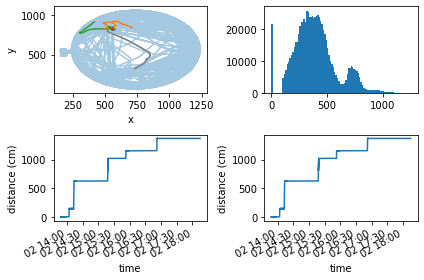

In [5]:
session = sessions.iloc[1]                                                    # pick a session
print('{0} on {1}...'.format(session.id, session.enter))                      # print session report
start = session.enter                                                         # session start time is session index
end = start + session.duration                                                # end time = start time + duration
position = aeon.load(root, exp02.CameraTop.Position, start=start, end=end)     # get position data between start and end
position = position[position.area < 2000]                                     # filter for objects of the correct size

encoder1 = aeon.load(root, exp02.Patch1.Encoder, start=start, end=end)        # get encoder data for patch1 between start and end
encoder2 = aeon.load(root, exp02.Patch2.Encoder, start=start, end=end)        # get encoder data for patch1 between start and end
pellets1 = aeon.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)  # get pellet events for patch1 between start and end
pellets2 = aeon.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)  # get pellet events for patch1 between start and end

wheel1 = distancetravelled(encoder1.angle)                                    # compute total distance travelled on patch1 wheel
wheel2 = distancetravelled(encoder2.angle)                                    # compute total distance travelled on patch2 wheel

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)                            # create a figure with subplots
ax1.plot(position.x, position.y, alpha=0.4)                                   # plot position data as a path trajectory
forage = position.reindex(pellets1.index, method='nearest')                   # get position data when a pellet is delivered at patch1
forage.plot.scatter('x','y',s=1,c='red',ax=ax1)                               # plot mouse positions when pellets were delivered

for trial in pellets1.itertuples():                                           # for each pellet delivery
    before = trial.Index - pd.to_timedelta(10, 's')                           # get the previous 10 seconds
    path = position.loc[before:trial.Index]                                   # get position data in the time before pellet delivery
    ax1.plot(path.x, path.y)                                                  # plot path traces preceding pellet delivery

ax2.hist(position.area, bins=100)                                             # plot histogram of tracked object size

wheel1.plot(ax=ax3)                                                           # plot distance travelled on patch1 wheel
wheel1.plot(ax=ax4)                                                           # plot distance travelled on patch2 wheel
ax3.set_ylabel('distance (cm)')                                               # set axis label
ax4.set_ylabel('distance (cm)')                                               # set axis label
fig.tight_layout()
plt.show()